<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML2/blob/main/WaveNet/Multi_Wavenet_SML2010_SingleStep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from keras import backend as K

# Initialisation TPU

In [2]:
import os

use_tpu = True

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TPU_ADDRESS = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TPU_ADDRESS = ''

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.16.45.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.16.45.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


# Chargement des données

In [3]:
# Récupération des données au format .csv
!rm *.csv
!wget --no-check-certificate --content-disposition "https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/LorenzMap.csv"

rm: cannot remove '*.csv': No such file or directory
--2021-08-17 09:22:53--  https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/LorenzMap.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34567 (34K) [text/plain]
Saving to: ‘LorenzMap.csv’

LorenzMap.csv       100%[===================>]  33.76K  --.-KB/s    in 0.002s  

2021-08-17 09:22:53 (16.3 MB/s) - ‘LorenzMap.csv’ saved [34567/34567]



Charge la série sous Pandas et affiche les informations du fichier :

In [4]:
# Création de la série sous Pandas
serie = pd.read_csv("LorenzMap.csv", names=['X','Y','Z'])
serie

,X,Y,Z
0,0.000000,1.00000,1.0500
1,0.048931,0.99832,1.0362
2,0.095542,1.00310,1.0227
3,0.140250,1.01400,1.0097
4,0.183460,1.03090,0.9971
...,...,...,...
1552,1.282300,-1.93910,25.2700
1553,0.901650,-1.87140,24.4010
1554,0.574140,-1.81070,23.5710
1555,0.292540,-1.76190,22.7750


In [5]:
serie = serie.astype(dtype='float32')
serie.dtypes

X    float32
Y    float32
Z    float32
dtype: object

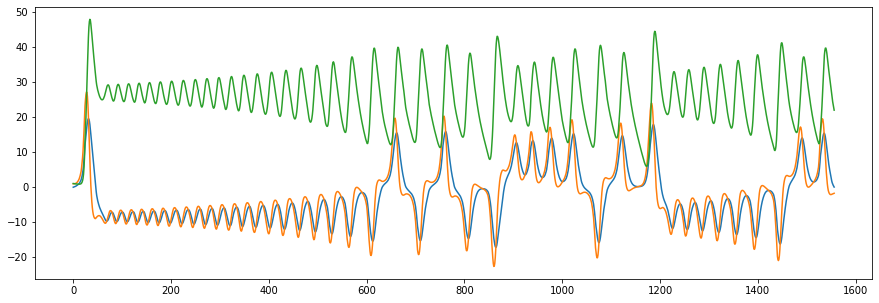

In [6]:
# Affiche la série
plt.figure(figsize=(15,5))
plt.plot(serie.index, serie['X'],serie['Y'])
plt.plot(serie.index, serie['Z'])


# Séparation des données de test et d'entrainement

In [7]:
# Sépare les données en entrainement et tests
pourcentage = 0.8
temps_separation = int(len(serie.values) * pourcentage)
date_separation = serie.index[temps_separation]

serie_entrainement_X = np.array(serie.values[:temps_separation],dtype=np.float32)
serie_test_X = np.array(serie.values[temps_separation:],dtype=np.float32)

print("Taille de l'entrainement : %d" %len(serie_entrainement_X))
print("Taille de la validation : %d" %len(serie_test_X))

Taille de l'entrainement : 1245
Taille de la validation : 312


**Normalisation des données :**

On normalise les données à l'aide de la fonction [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [8]:
from sklearn import preprocessing

# Constrution des séries
serie_entrainement_X_norm = []
serie_test_X_norm = []

for i in range(0,len(serie.columns)):
  serie_entrainement_X_norm.append(serie_entrainement_X[:,i])
  serie_test_X_norm.append(serie_test_X[:,i])

serie_entrainement_X_norm = tf.convert_to_tensor(serie_entrainement_X_norm)
serie_entrainement_X_norm = tf.transpose(serie_entrainement_X_norm)
serie_test_X_norm = tf.convert_to_tensor(serie_test_X_norm)
serie_test_X_norm = tf.transpose(serie_test_X_norm)

# Initialisaton du MinMaxScaler
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(serie_entrainement_X_norm)

# Normalisation des séries
serie_entrainement_X_norm = min_max_scaler.transform(serie_entrainement_X_norm)
serie_test_X_norm = min_max_scaler.transform(serie_test_X_norm)

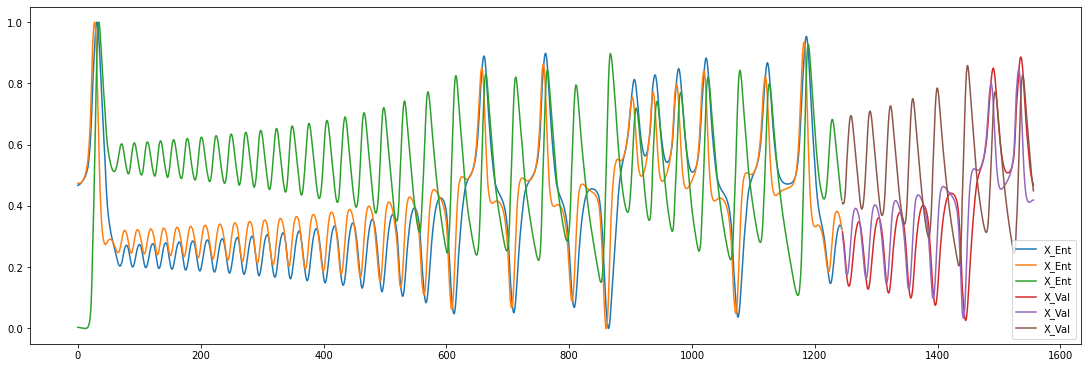

In [9]:
# Affiche quelques séries
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

ax.plot(serie.index[:temps_separation].values,serie_entrainement_X_norm[:,0:5], label="X_Ent")
ax.plot(serie.index[temps_separation:].values,serie_test_X_norm[:,0:5], label="X_Val")

ax.legend()
plt.show()

# Création du modèle type Wavenet Multivarié - Multipas

<img src="https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Wavenet/images/Wavenet_finance.png?raw=true">

<img src="https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Wavenet/images/Wavenet_finance_Multi.png?raw=true">

**1. Création du réseau**

In [65]:
import keras.backend as K

def get_model(longueur_sequence, longueur_sortie, dim_exo, nbr_filtres, dim_filtres, prodondeur_dilation, use_bias, res_l2, final_l2,batch_size):
  input_shape_exo = tf.keras.Input(shape=(longueur_sequence, dim_exo), name='input_exo')
  input_shape_cibles = tf.keras.Input(shape=(longueur_sequence, 1), name='input_cible')

  entree_exo = input_shape_exo
  entree_cibles = input_shape_cibles

  sorties = []

  for t in range(longueur_sortie):
    # Convolution causale d'entrée des séries exogènes
    # out_exo : (batch_size,longueur_sequence,dim_exo)
    out_exo = K.temporal_padding(entree_exo, padding=((dim_filtres - 1), 0))
    out_exo = tf.keras.layers.Conv1D(filters=nbr_filtres,kernel_size=dim_filtres,dilation_rate=1,use_bias=True,activation=None,
                              name='convolution_causale_exo_%i' %t,kernel_regularizer=tf.keras.regularizers.l2(res_l2))(out_exo)
          
    # Convolution causale d'entrée de la série cible
    # out_cible : (batch_size,longueur_sequence,1)
    out_cible = K.temporal_padding(entree_cibles, padding=((dim_filtres - 1), 0))
    out_cible = tf.keras.layers.Conv1D(filters=nbr_filtres,kernel_size=dim_filtres,dilation_rate=1,use_bias=True,activation=None,
                              name='convolution_causale_cible_%i' %t,kernel_regularizer=tf.keras.regularizers.l2(res_l2))(out_cible)
    
    # Convolutions dilatées #1 sur les séries exogènes
    # res_exo : (batch_size,longueur_sequence,dim_exo)
    skip = []
    z_exo = K.temporal_padding(out_exo, padding=(2*(dim_filtres - 1), 0))
    z_exo = tf.keras.layers.Conv1D(filters=nbr_filtres,kernel_size=dim_filtres,dilation_rate=2,use_bias=True,activation="relu",
                              name='convolution_dilatee_exo_1_%i' %t, kernel_regularizer=tf.keras.regularizers.l2(res_l2))(z_exo)

    skip_exo = tf.keras.layers.Conv1D(dim_exo, 1, padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(res_l2))(z_exo)
    res_exo = tf.keras.layers.Conv1D(dim_exo, 1, padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(res_l2))(z_exo)

    # Convolutions dilatées #1 sur la cible
    # res_cible : (batch_size,longueur_sequence,1)
    z_cible = K.temporal_padding(out_cible, padding=(2*(dim_filtres - 1), 0))
    z_cible = tf.keras.layers.Conv1D(filters=nbr_filtres,kernel_size=dim_filtres,dilation_rate=2,use_bias=True,activation="relu",
                              name='convolution_dilatee_cible_1_%i' %t, kernel_regularizer=tf.keras.regularizers.l2(res_l2))(z_cible)
    skip_cible = tf.keras.layers.Conv1D(1, 1, padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(res_l2))(z_cible)
    res_cible = tf.keras.layers.Conv1D(1, 1, padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(res_l2))(z_cible)

    # Sauvegarde des sorties intermédiaires
    # skip_exo : (batch_size,longueur_sequence,dim_exo)
    # skip_cible : (batch_size,longueur_sequence,1)
    skip.append(tf.concat([skip_exo,skip_cible],axis=2))

    # Connexions résiduelles des séries exogènes et de la cible
    # res_exo : (batch_size,longueur_sequence,dim_exo)
    # res_cible : (batch_size,longueur_sequence,1)
    res_x_exo = tf.keras.layers.Add()([entree_exo, res_exo])
    res_x_cible = tf.keras.layers.Add()([entree_cibles, res_cible])

    # Concaténation des connexions résiduelles
    # res_x : (batch_size,longueur_sequence,dim_exo+1)
    res_x = tf.concat([res_x_exo, res_x_cible],axis=2)
    out = res_x

    # Convolutions dilatées intermédiaires
    for i in range(2, prodondeur_dilation + 1):
      z = K.temporal_padding(res_x, padding=(2**i * (dim_filtres - 1), 0))
      z = tf.keras.layers.Conv1D(filters=nbr_filtres,kernel_size=dim_filtres,dilation_rate=2**i,use_bias=True,activation="relu",
                              name='convolution_dilatee_%i_%i' %(i,t), kernel_regularizer=tf.keras.regularizers.l2(res_l2))(z)

      skip_x = tf.keras.layers.Conv1D(dim_exo+1, 1, padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(res_l2))(z)
      res_x = tf.keras.layers.Conv1D(dim_exo+1, 1, padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(res_l2))(z)

      res_x = tf.keras.layers.Add()([out, res_x])     # (batch_size,longueur_sequence,dim_exo+1)
      out = res_x
      skip.append(skip_x)                             # (batch_size,longueur_sequence,dim_exo+1)
    
    # Addition des sorties intermédiaires
    out = tf.keras.layers.Add()(skip)                 # (batch_size,longueur_sequence,dim_exo+1)

    # Couche de sortie de la cible et des séries exogènes
    # sorties : (batch_size,1,1)
    # out_exo : (batch_size,longueur_sequence,dim_exo)
    out = tf.keras.layers.Activation('linear', name="output_linear_%i" %t)(out)
    out_cible = tf.keras.layers.Conv1D(1, 1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(final_l2))(out)
    out_exo = tf.keras.layers.Conv1D(dim_exo, 1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(final_l2))(out)
    sorties.append(out_cible[:,-1:,:])

    # Ajustement de l'entree des séries exogènes à (t+i+1)
    entree_exo = tf.concat([entree_exo,out_exo[:,-1:,:]],axis=1)
    entree_exo = tf.slice(entree_exo,[0,1,0],[batch_size,input_shape_exo.shape[1],dim_exo])
  
    # Ajustement de l'entree cible à (t+i+1)
    entree_cibles = tf.concat([entree_cibles,out_cible[:,-1:,:]],axis=1)
    entree_cibles = tf.slice(entree_cibles,[0,1,0],[batch_size,input_shape_cibles.shape[1],1])

  sorties = tf.convert_to_tensor(sorties)             # (longueur_sortie,batch_size,1,1)
  sorties = tf.squeeze(sorties,-1)                    # (longueur_sortie,batch_size,1)
  sorties = tf.transpose(sorties,perm=[1,0,2])        # (batch_size,longueur_sortie,1)

  model = tf.keras.Model([input_shape_exo,input_shape_cibles], sorties)
  return model


**2. Construction du modèle**

In [15]:
def calcul_longueur_sequence(prodondeur_dilation):
  return (2 ** prodondeur_dilation * 2)

In [ ]:
nbr_filtres = 2
dim_filtres = 2
profondeur_dilation = 3         # longueur_sequence = 16
use_bias = False
res_l2 = 0
final_l2 = 0

batch_size = 128
longueur_sortie = 5
dim_exo = 2

longueur_sequence = calcul_longueur_sequence(profondeur_dilation)
print(longueur_sequence)

model = get_model(longueur_sequence, longueur_sortie, dim_exo, nbr_filtres, dim_filtres, profondeur_dilation, use_bias, res_l2, final_l2,batch_size=batch_size)
model.summary()

# Création des datasets

In [89]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# X = {((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T)),
#       (Y1,Y2,...,YT)}
# Y = YT+1

def prepare_dataset_XY(seriesX, serieY, longueur_sequence, longueur_sortie, batch_size,shift):
  datasetX = tf.data.Dataset.from_tensor_slices(seriesX)
  datasetX = datasetX.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetX = datasetX.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetX = datasetX.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetX = datasetX.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetY = tf.data.Dataset.from_tensor_slices(serieY)
  datasetY = datasetY.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetY = datasetY.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetY = datasetY.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetY = datasetY.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetYPred = tf.data.Dataset.from_tensor_slices(serieY)
  datasetYPred = datasetYPred.window(longueur_sequence+longueur_sortie+1, shift=shift, drop_remainder=True)
  datasetYPred = datasetYPred.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie+1))
  datasetYPred = datasetYPred.map(lambda x: (x[0:-1][-longueur_sortie:,:]))
  datasetYPred = datasetYPred.batch(batch_size,drop_remainder=True).prefetch(1)


  dataset = tf.data.Dataset.zip((datasetX,datasetY))
  dataset = tf.data.Dataset.zip((dataset,datasetYPred))

  return dataset

In [90]:
# Définition des caractéristiques du dataset que l'on souhaite créer
shift=1

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement_X_norm[:,0:-1],serie_entrainement_X_norm[:,-1:], longueur_sequence,longueur_sortie,batch_size,shift)
dataset_val = prepare_dataset_XY(serie_test_X_norm[:,0:-1],serie_test_X_norm[:,-1:],longueur_sequence,longueur_sortie,batch_size,shift)

In [91]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # (Y1,Y2,...,YT)
  print(element[1].shape)               # YT+1

9
(128, 16, 2)
(128, 16, 1)
(128, 5, 1)


In [92]:
print(len(list(dataset_val.as_numpy_iterator())))
for element in dataset_val.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # Y1,Y2,...,YT
  print(element[1].shape)               # YT+1

2
(128, 16, 2)
(128, 16, 1)
(128, 5, 1)


**3. Préparation des X/Y**

In [93]:
X1 = []
X2 = []

# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset))              # x=43x((BS,10,3),(BS,9,1))
                                        # y=43x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])          
  X2.append(x[i][1])

X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)   

# Recombine les données
y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

x_train = [X1,X2]
y_train = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_train[0].shape)
print(x_train[1].shape)
print(y_train.shape)


(1152, 16, 2)
(1152, 16, 1)
(1152, 5, 1)


In [94]:
X1 = []
X2 = []

# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset_val))              # x=43x((BS,10,3),(BS,9,1))
                                        # y=43x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])          
  X2.append(x[i][1])

X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)   

# Recombine les données
y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

x_val = [X1,X2]
y_val = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_val[0].shape)
print(x_val[1].shape)
print(y_val.shape)


(256, 16, 2)
(256, 16, 1)
(256, 5, 1)


# Entrainement avec TPU

In [ ]:
from google.colab import files

max_periodes = 1000

strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  # Création du modèle
  model = get_model(longueur_sequence, longueur_sortie, nbr_filtres, dim_exo, dim_filtres, profondeur_dilation, use_bias, res_l2, final_l2, batch_size=int(batch_size/8))

  # Définition des paramètres liés à l'évolution du taux d'apprentissage
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      initial_learning_rate=0.005,
      decay_steps=50,
      decay_rate=0.01)

  optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

  # Utilisation de la méthode ModelCheckPoint
  CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

  # Compile le modèle
  model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

  # Entraine le modèle
  historique = model.fit(x=[x_train[0],x_train[1]],y=y_train, validation_data=([x_val[0],x_val[1]],y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200)],batch_size=batch_size)


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/1000
9/9 [==============================] - 25s 384ms/step - loss: 0.5286 - mse: 0.5286 - val_loss: 0.1610 - val_mse: 0.1610

Epoch 00001: loss improved from inf to 0.52861, saving model to poids_train.hdf5
Epoch 2/1000
9/9 [==============================] - 1s 64ms/step - loss: 0.1146 - mse: 0.1146 - val_loss: 0.0926 - val_mse: 0.0926

Epoch 00002: loss improved from 0.52861 to 0.11455, saving model to poids_train.hdf5
Epoch 3/1000
9/9 [==============================] - 1s 64ms/step - loss: 0.0786 - mse: 0.0786 - val_loss: 0.0528 - val_mse: 0.0528

Epoch 00003: loss improved from 0.11455 to 0.07855, saving model to poids_train.hdf5
Epoch 4/1000
9/9 [==============================] - 1s 65ms/step - loss: 0.0472 - mse: 0.0472 - val_loss: 0.0401 - val_mse: 0.0401

Epoch 00004: loss improved from 0.07855 to 0.04718, saving model to poids_train.hdf5
Epoch 5/1000
9/9 [==============================] - 1s 64ms/step - loss: 0.0367 - mse: 0.0367 - val_loss: 0.0318 - val_mse: 0.0318

Ep

In [ ]:
files.download('poids_train.hdf5')

In [99]:
model.load_weights("poids_train.hdf5")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

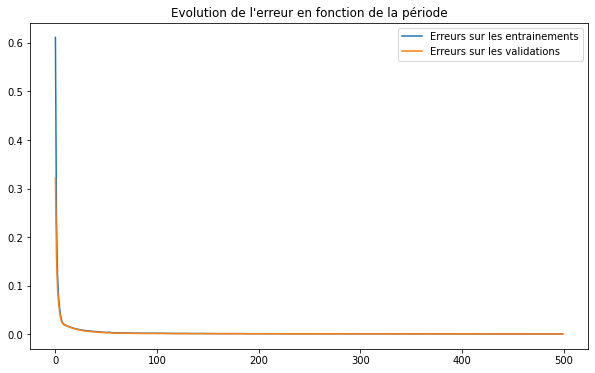

In [100]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

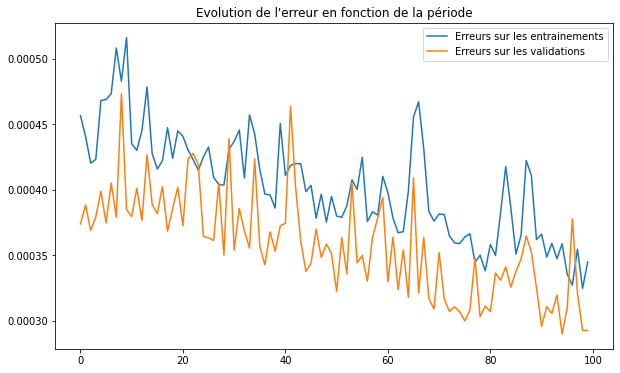

In [101]:
start = 400

erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement[start:])),erreur_entrainement[start:], label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement[start:])),erreur_validation[start:], label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

# Chargement du modèle pré-entrainé


**LorenzMap_Wavenet_Univarié - SingleStep**  
  - Single step  
  - profondeur dilation : 3 (longueur_sequence = 16)
  - dim_filtres = 2
  - nbr_filtres = 2
  - régul = 0


In [ ]:
!rm *.hdf5
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Wavenet/LorenzMap_Wavenet_Multi-SingleStep.hdf5"

In [ ]:
model = get_model()

In [ ]:
model.load_weights("LorenzMap_Wavenet_Multi-SingleStep.hdf5")


**LorenzMap_Wavenet_Univarié - MultiStep**  
  - longueur sortie : 5  
  - profondeur dilation : 3 (longueur_sequence = 16)
  - dim_filtres = 2
  - nbr_filtres = 2
  - régul = 0


In [ ]:
!rm *.hdf5
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Wavenet/LorenzMap_Wavenet_Multi-MultiStep.hdf5"

In [ ]:
model = get_model()

In [ ]:
model.load_weights("LorenzMap_Wavenet_Multi-MultiStep.hdf5")

# Prédictions single-step

In [102]:
pred_ent = model.predict((x_train[0],x_train[1]),verbose=1)
pred_val = model.predict((x_val[0],x_val[1]),verbose=1)

ValueError: ignored

In [83]:
import plotly.graph_objects as go

decalage = 1

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=serie.index,y=serie_entrainement_X_norm[:,-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=serie.index[temps_separation:],y=serie_test_X_norm[:,-1],line=dict(color='red', width=1)))

#Affiche les prédictions sur l'entrainement
pred = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=serie.index[longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

#Affiche les prédictions sur les validations
pred = []
max = len(pred_val)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:decalage,:],1))

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=serie.index[temps_separation+longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**Erreurs en single step**

In [84]:
import plotly.graph_objects as go

fig = go.Figure()

decalage = 1
pred = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=serie.index[longueur_sequence:],y=serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=serie.index[longueur_sequence:],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_ent = tf.keras.losses.mse(serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)

In [85]:
import plotly.graph_objects as go

fig = go.Figure()

decalage = 1
pred = []

max = len(pred_val)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=serie.index[temps_separation+longueur_sequence::],y=serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=serie.index[temps_separation+longueur_sequence::],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_test = tf.keras.losses.mse(serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)

In [86]:
print(mse_ent)
print(mse_test)

tf.Tensor(7.500052e-05, shape=(), dtype=float32)
tf.Tensor(5.6795085e-05, shape=(), dtype=float32)


# Prédictions Multistep

In [104]:
pred_ent = model.predict((x_train[0],x_train[1]),verbose=1,batch_size=batch_size)
pred_val = model.predict((x_val[0],x_val[1]),verbose=1,batch_size=batch_size)

2/2 [==============================] - 0s 12ms/step


In [105]:
import plotly.graph_objects as go

decalage = longueur_sortie

fig = go.Figure()

# Affiche les courbes originales
fig.add_trace(go.Scatter(x=serie.index,y=tf.squeeze(serie_entrainement_X_norm[:,-1:],-1),line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=serie.index[temps_separation:],y=tf.squeeze(serie_test_X_norm[:,-1:],-1),line=dict(color='red', width=1)))

#Calcul les prédictions sur l'entrainement
pred = []
pred_index = []
step_time = []
step_val = []

max = int(len(pred_ent)/longueur_sortie)
#max = 10
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i*longueur_sortie,0:decalage,:],1))
  pred_index.append(serie.index[longueur_sequence+i*longueur_sortie:longueur_sequence+(i+1)*longueur_sortie])
  step_val.append(pred_ent[i*longueur_sortie,0,0])
  step_time.append(serie.index[longueur_sequence+i*longueur_sortie])

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

pred_index = np.asarray(pred_index)
pred_index = np.reshape(pred_index,(pred_index.shape[0]*pred_index.shape[1]))

fig.add_trace(go.Scatter(x=pred_index,y=pred, mode='lines', line=dict(color='green', width=1)))
fig.add_trace(go.Scatter(x=step_time,y=step_val, mode='markers', line=dict(color='black', width=1)))

#Calcul les prédictions sur les validations
pred = []
pred_index = []
step_time = []
step_val = []
max = int(len(pred_val)/longueur_sortie)
#max = 10
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i*longueur_sortie,0:decalage,:],1))
  pred_index.append(serie.index[temps_separation+i*decalage+longueur_sequence:temps_separation+i*decalage+longueur_sequence+longueur_sortie])
  step_val.append(pred_val[i*longueur_sortie,0,0])
  step_time.append(serie.index[temps_separation+i*decalage+longueur_sequence])

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))
pred_index = np.asarray(pred_index)
pred_index = np.reshape(pred_index,(pred_index.shape[0]*pred_index.shape[1]))

fig.add_trace(go.Scatter(x=pred_index,y=pred, mode='lines', line=dict(color='green', width=1)))
fig.add_trace(go.Scatter(x=step_time,y=step_val, mode='markers', line=dict(color='black', width=1)))

# Affiche les prédictions
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**Erreurs en multi step**

In [106]:
import plotly.graph_objects as go

fig = go.Figure()

decalage = longueur_sortie

#Calcul les prédictions sur l'entrainement
pred = []
pred_index = []
step_time = []
step_val = []

max = int(len(pred_ent)/longueur_sortie)
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i*longueur_sortie,0:decalage,:],1))

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=serie.index[longueur_sequence:],y=serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=serie.index[longueur_sequence:],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_ent = tf.keras.losses.mse(serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)

In [107]:
import plotly.graph_objects as go

fig = go.Figure()

#Calcul les prédictions sur les validations
pred = []
max = int(len(pred_val)/longueur_sortie)
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i*longueur_sortie,0:decalage,:],1))

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=serie.index[temps_separation+longueur_sequence::],y=serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=serie.index[temps_separation+longueur_sequence::],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_test = tf.keras.losses.mse(serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)

In [108]:
print(mse_ent)
print(mse_test)

tf.Tensor(0.00031942714, shape=(), dtype=float32)
tf.Tensor(0.000271038, shape=(), dtype=float32)
